#### Data Processing
##### Understanding the Dataset

The Stack Overflow Developer Survey dataset contains insights into developer demographics, work environments, compensation, technology preferences, and career satisfaction. This dataset is useful for identifying trends in job satisfaction and predicting key factors that influence developer happiness.

In [1]:
import pandas as pd

# Load the dataset
survey_data_path = "C:/Users/onkar/Downloads/survey_results_public.csv"
#schema_data_path = "/Users/janhavipatil/Desktop/stack-overflow-developer-survey-2024/survey_results_schema.csv"

# Read the datasets
survey_df = pd.read_csv(survey_data_path, low_memory=False)
#schema_df = pd.read_csv(schema_data_path, low_memory=False)

# Display first few rows of the dataset to understand its structure
print("Survey Dataset:")
print(survey_df.head())

# Display the column names to identify key variables
print("\nColumn Names:")
print(survey_df.columns)

# Check for missing values in the dataset
missing_values = survey_df.isnull().sum()
print("\nMissing Values:")
print(missing_values[missing_values > 0])

# Check data types to ensure proper handling of columns
print("\nData Types:")
print(survey_df.dtypes)

# Check if there are any duplicates
duplicates = survey_df.duplicated().sum()
print(f"\nNumber of Duplicates: {duplicates}")

# Check for basic summary statistics for numerical columns
print("\nSummary Statistics:")
print(survey_df.describe())

# Handling missing values
# Drop columns with more than 50% missing values
threshold = len(survey_df) * 0.5
survey_df = survey_df.dropna(thresh=threshold, axis=1)

# Fill missing values for numerical columns with median
num_cols = survey_df.select_dtypes(include=['number']).columns
survey_df[num_cols] = survey_df[num_cols].fillna(survey_df[num_cols].median())

# Fill missing values for categorical columns with mode
cat_cols = survey_df.select_dtypes(include=['object']).columns
survey_df[cat_cols] = survey_df[cat_cols].fillna(survey_df[cat_cols].mode().iloc[0])

# Verify missing values handled
print("\nMissing Values After Cleaning:")
print(survey_df.isnull().sum().sum())
survey_df.to_csv("survey_results_public_cleaned.csv", index=False)


Survey Dataset:
   ResponseId                      MainBranch                 Age  \
0           1  I am a developer by profession  Under 18 years old   
1           2  I am a developer by profession     35-44 years old   
2           3  I am a developer by profession     45-54 years old   
3           4           I am learning to code     18-24 years old   
4           5  I am a developer by profession     18-24 years old   

            Employment RemoteWork   Check  \
0  Employed, full-time     Remote  Apples   
1  Employed, full-time     Remote  Apples   
2  Employed, full-time     Remote  Apples   
3   Student, full-time        NaN  Apples   
4   Student, full-time        NaN  Apples   

                                    CodingActivities  \
0                                              Hobby   
1  Hobby;Contribute to open-source projects;Other...   
2  Hobby;Contribute to open-source projects;Other...   
3                                                NaN   
4                 

## Approach Summary:

### Data Loading:
- **Objective**: Load the dataset from a specified file path.
- **Method**: Use `pandas.read_csv()` to read the CSV file, ensuring robust error handling with `try-except`.

### Data Cleaning:
- **Objective**: Clean the data to ensure numeric columns are properly formatted.
- **Method**: Convert the `YearsCodePro` column to numeric, using `pd.to_numeric()` to handle any errors and coerce invalid values into `NaN`.

### Feature Engineering:
- **Objective**: Create new features based on existing ones to improve model understanding.
- **Method**: Create a new column (`JobSat`) to categorize job satisfaction based on the `YearsCodePro` value:
    - `Satisfied`: 10+ years of experience
    - `Neutral`: Between 5 and 10 years
    - `Dissatisfied`: Less than 5 years

### Handling Missing Values:
- **Objective**: Remove rows with missing values in key columns (target variable `JobSat`).
- **Method**: Use `dropna()` to remove rows where the `JobSat` column has missing values.

### Splitting the Data:
- **Objective**: Split the data into training and test sets while maintaining the class distribution.
- **Method**: Use `train_test_split()` from `sklearn` with stratification based on the target column `JobSat`.

### Feature Selection:
- **Objective**: Choose relevant features for model training.
- **Method**: Select a list of relevant features, then drop any rows with missing values in the selected columns.

### Preprocessing:
- **Objective**: Normalize numeric features and encode categorical variables.
- **Method**: Use `ColumnTransformer` with:
    - `StandardScaler` for numerical features like `YearsCodePro`.
    - `OneHotEncoder` for categorical variables (to handle categorical features like `EdLevel`, `Employment`, etc.).


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE

# Load dataset
def load_data(file_path):
    try:
        df = pd.read_csv(file_path, low_memory=False)
        print("Data loaded successfully!")
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

# Clean and convert 'YearsCodePro' to numeric
def clean_years_code_pro(df):
    df['YearsCodePro'] = pd.to_numeric(df['YearsCodePro'], errors='coerce')
    return df

# Categorize job satisfaction into 3 categories
def categorize_job_satisfaction(df):
    conditions = [
        (df['YearsCodePro'] >= 10),
        (df['YearsCodePro'] < 10) & (df['YearsCodePro'] >= 5),
        (df['YearsCodePro'] < 5)
    ]
    choices = ['Satisfied', 'Neutral', 'Dissatisfied']
    df['JobSat'] = np.select(conditions, choices, default='Neutral')
    return df

# Perform oversampling using SMOTE
def oversample_minority_class(X_train, y_train):
    smote = SMOTE(random_state=42)
    return smote.fit_resample(X_train, y_train)

# Split data
def split_data(df, target_col):
    X = df.drop(columns=[target_col])
    y = df[target_col]
    print("Class distribution before splitting:\n", y.value_counts())
    return train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Load the dataset
survey_data_path = "survey_results_public_cleaned.csv"
df = load_data(survey_data_path)

if df is not None:
    df = clean_years_code_pro(df)
    df = categorize_job_satisfaction(df)
    df = df.dropna(subset=['JobSat'])  # Remove missing values in target column

    print("Data preview with JobSat Column:\n", df[['JobSat', 'YearsCodePro']].head())

    # Define target variable and features
    target_col = 'JobSat'
    features = ['YearsCodePro', 'Age', 'EdLevel', 'Employment', 'RemoteWork', 'CodingActivities', 'LearnCode',
                'LearnCodeOnline', 'TechDoc', 'DevType', 'OrgSize', 'Country', 'Currency', 'LanguageHaveWorkedWith',
                'LanguageWantToWorkWith', 'DatabaseHaveWorkedWith', 'PlatformHaveWorkedWith', 'WebframeHaveWorkedWith',
                'MiscTechHaveWorkedWith', 'ToolsTechHaveWorkedWith', 'OpSysPersonal use', 'OpSysProfessional use',
                'AISearchDevHaveWorkedWith', 'AISearchDevWantToWorkWith', 'AISearchDevAdmired', 'SOVisitFreq', 'SOAccount',
                'SOHow', 'SOComm', 'AISelect', 'AISent', 'AIBen', 'AIAcc', 'AIComplex', 'AIToolCurrently Using', 'AIThreat',
                'AIEthics', 'AIChallenges', 'TBranch', 'SurveyLength', 'SurveyEase']

    df = df[features + [target_col]].dropna()  # Keep only relevant columns

    # Split data
    X_train, X_test, y_train, y_test = split_data(df, target_col)
    print("Class distribution in training set:\n", y_train.value_counts())

    # Define feature types
    numeric_features = ['YearsCodePro']
    categorical_features = [col for col in features if col not in numeric_features]

    # Preprocessing pipeline
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

    # Apply preprocessing
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)

    # Apply SMOTE
    X_train_resampled, y_train_resampled = oversample_minority_class(X_train, y_train)
    print("Class distribution after SMOTE:\n", pd.Series(y_train_resampled).value_counts())

    print("\nData Preprocessing Completed Successfully!")
else:
    print("Data is empty. Please check the file.")

Data loaded successfully!
Data preview with JobSat Column:
          JobSat  YearsCodePro
0  Dissatisfied           2.0
1     Satisfied          17.0
2     Satisfied          27.0
3  Dissatisfied           2.0
4  Dissatisfied           2.0
Class distribution before splitting:
 JobSat
Dissatisfied    27942
Satisfied       21661
Neutral         12928
Name: count, dtype: int64
Class distribution in training set:
 JobSat
Dissatisfied    22353
Satisfied       17329
Neutral         10342
Name: count, dtype: int64
Class distribution after SMOTE:
 JobSat
Dissatisfied    22353
Satisfied       22353
Neutral         22353
Name: count, dtype: int64

Data Preprocessing Completed Successfully!


## Approach Summary:

### Apply SMOTE Oversampling:
- **Objective**: Balance the class distribution in the training data by generating synthetic samples for the minority class.
- **Method**: Use **SMOTE (Synthetic Minority Over-sampling Technique)** from the `imblearn` library to resample the minority class.

### Feature Selection Using Random Forest Importance:
- **Objective**: Select the most important features for training the model, based on feature importance.
- **Method**: Train a `RandomForestClassifier` to identify important features, then select the top `num_features` (default: 50) based on their importance scores.

### Hyperparameter Tuning:
- **Objective**: Find the optimal hyperparameters for the `RandomForestClassifier` using randomized search.
- **Method**: Use `RandomizedSearchCV` to tune the model’s hyperparameters, including `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`, `max_features`, and `class_weight`.

### Train and Evaluate Model:
- **Objective**: Train the model, evaluate performance, and check for overfitting.
- **Method**:
    - **Data Resampling**: Apply SMOTE to balance the classes.
    - **Feature Selection**: Use Random Forest to select important features.
    - **Model Training**: Train the `RandomForestClassifier` with the selected features.
    - **Performance Metrics**: Evaluate the model using **accuracy**, **precision**, **recall**, and **F1-score**.
    - **Cross-Validation**: Use `StratifiedKFold` to perform cross-validation and compute the average score.
    - **Overfitting Check**: Calculate the difference between training accuracy and test accuracy to detect overfitting.
    - **Confusion Matrix**: Plot the confusion matrix to visualize the model's performance.

### Run Model Training:
- **Objective**: Execute the training and evaluation of the `RandomForestClassifier` model.
- **Method**: Call the `train_and_evaluate_rf()` function with the training and testing data.



Random Forest Model Performance:
Accuracy: 0.9751 
Precision: 0.9750 
Recall: 0.9751 
F1-Score: 0.9749

Cross-Validation Score: 0.9713 (+/- 0.0105) 
Overfitting Value: 0.0052


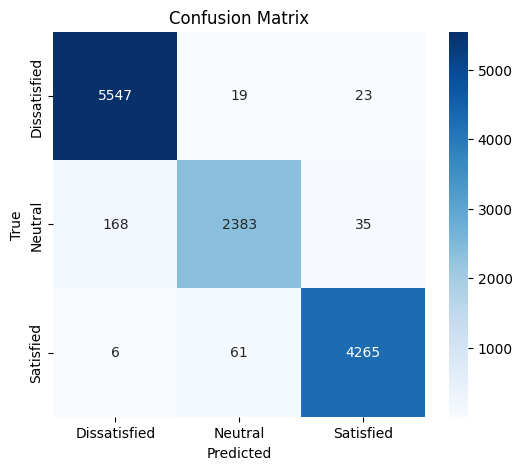

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer

# Apply SMOTE Oversampling
def balance_classes(X_train, y_train):
    smote = SMOTE(random_state=42)
    return smote.fit_resample(X_train, y_train)

# Feature Selection Using Random Forest Importance
def select_important_features(X_train, y_train, X_test, num_features=50):
    rf_temp = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    rf_temp.fit(X_train, y_train)
    indices = np.argsort(rf_temp.feature_importances_)[::-1][:num_features]

    return X_train[:, indices], X_test[:, indices]

# Hyperparameter Tuning
def tune_rf_hyperparameters(X_train, y_train):
    param_dist = {
        'n_estimators': [100, 120],
        'max_depth': [5, 6],
        'min_samples_split': [10, 15],
        'min_samples_leaf': [10, 15],
        'max_features': ['sqrt'],
        'bootstrap': [True],
        'class_weight': ['balanced_subsample']
    }

    rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
    random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist,
                                       n_iter=3, cv=3, n_jobs=-1, random_state=42)
    random_search.fit(X_train, y_train)
    return random_search.best_estimator_

# Train and Evaluate Model
def train_and_evaluate_rf(X_train, X_test, y_train, y_test):
    X_train_resampled, y_train_resampled = balance_classes(X_train, y_train)
    X_train_selected, X_test_selected = select_important_features(X_train_resampled, y_train_resampled, X_test)

    rf_model = tune_rf_hyperparameters(X_train_selected, y_train_resampled)
    rf_model.fit(X_train_selected, y_train_resampled)
    y_pred_rf = rf_model.predict(X_test_selected)

    # Model Performance Metrics
    accuracy = accuracy_score(y_test, y_pred_rf)
    precision_rf = precision_score(y_test, y_pred_rf, average='weighted', zero_division=0)
    recall_rf = recall_score(y_test, y_pred_rf, average='weighted', zero_division=0)
    f1_rf = f1_score(y_test, y_pred_rf, average='weighted', zero_division=0)

    print("\nRandom Forest Model Performance:")
    print(f"Accuracy: {accuracy:.4f} \nPrecision: {precision_rf:.4f} \nRecall: {recall_rf:.4f} \nF1-Score: {f1_rf:.4f}")

    # Cross-Validation
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    cv_scores = cross_val_score(rf_model, X_train_selected, y_train_resampled, cv=skf, scoring=make_scorer(accuracy_score))

    # Overfitting Check
    overfitting_value = accuracy_score(y_train_resampled, rf_model.predict(X_train_selected)) - accuracy
    print(f"\nCross-Validation Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f}) \nOverfitting Value: {overfitting_value:.4f}")

    # Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    return rf_model, X_train_selected, X_test_selected, y_train_resampled, y_test, y_pred_rf, cv_scores

# Run Model Training
rf_model, X_train_selected, X_test_selected, y_train_resampled, y_test, y_pred_rf, cv_scores = train_and_evaluate_rf(X_train, X_test, y_train, y_test)

## Approach Summary:

### Data Preprocessing and SMOTE Oversampling:
- **Objective**: Balance the class distribution in the training set to avoid bias towards the majority class.
- **Method**:
    - **SMOTE (Synthetic Minority Over-sampling Technique)**: Applied to ensure that the minority classes are oversampled to match the size of the majority class, preventing underrepresentation of any class.
    - **Standardization**: Standardized the features using `StandardScaler` to scale the data. The `with_mean=False` argument is used for sparse matrices.

### Feature Selection:
- **Objective**: Reduce the number of features to make the model more efficient and less prone to overfitting.
- **Method**: Use **SelectKBest** with **f_classif** scoring to select the top 15 features from the original dataset, based on their statistical significance (ANOVA F-value).

### Hyperparameter Tuning:
- **Objective**: Tune the hyperparameters of the Logistic Regression model to improve its performance.
- **Method**: Perform hyperparameter tuning using **GridSearchCV** with cross-validation to find the optimal values for:
    - `C`: Regularization parameter (values: 0.1, 1.0)
    - `solver`: Optimization algorithm (set to `'lbfgs'` for better stability)
    - `max_iter`: Maximum number of iterations for convergence (set to 500)

### Model Training and Evaluation:
- **Objective**: Train the Logistic Regression model and evaluate its performance.
- **Method**:
    - **Training**: The model is trained using the best hyperparameters found via **GridSearchCV**.
    - **Model Evaluation**: The performance is evaluated using multiple metrics including **accuracy**, **precision**, **recall**, and **F1-score** (weighted average).
    - **Overfitting Check**: Measure overfitting by calculating the difference between training and test accuracy.
    - **Confusion Matrix**: A confusion matrix is plotted to visualize the model's performance on the test set.

### Running the Model:
- **Objective**: Execute the training and evaluation of the Logistic Regression model with the provided training and testing datasets (`X_train`, `X_test`, `y_train`, `y_test`).
- **Method**: Call the function `train_and_evaluate_lr()` to run the model training and evaluation.



Adjusted Logistic Regression Model Performance:
Accuracy: 1.0000 
Precision: 1.0000 
Recall: 1.0000 
F1-Score: 1.0000

Overfitting Measure (Train - Test Accuracy): 0.0000


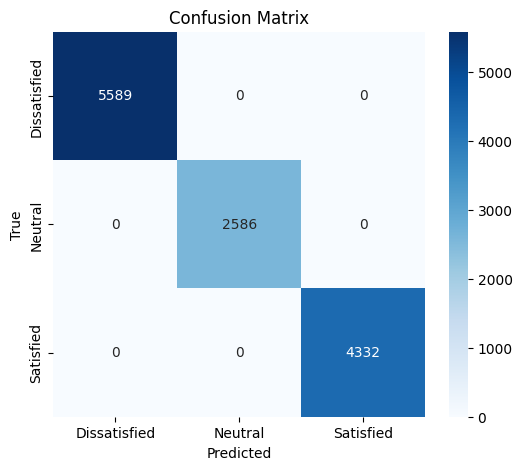

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE

# Apply SMOTE with controlled sampling to ensure no class has fewer samples than originally
def balance_classes(X_train, y_train):
    class_counts = dict(zip(*np.unique(y_train, return_counts=True)))
    max_class_count = max(class_counts.values())  # Get the maximum class count

    smote = SMOTE(random_state=42, sampling_strategy={class_label: max_class_count for class_label in class_counts})
    return smote.fit_resample(X_train, y_train)


# Feature Selection (Reduce from 20 to 15)
def select_best_features(X_train, X_test, y_train, k=50):
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    return X_train_selected, X_test_selected

# Train and Evaluate Logistic Regression Model
def train_and_evaluate_lr(X_train, X_test, y_train, y_test):
    try:
        X_train, y_train = balance_classes(X_train, y_train)
    except ValueError as e:
        print(e)
        return

    # Standardization (Fixed: with_mean=False for sparse matrices)
    scaler = StandardScaler(with_mean=False)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Feature Selection (Reduced to 15 features)
    X_train, X_test = select_best_features(X_train, X_test, y_train, k=50)

    # Hyperparameter Tuning (Reduced complexity)
    param_grid = {
        'C': [0.1, 1.0],
        'solver': ['lbfgs'],
        'max_iter': [500]
    }

    lr_model = GridSearchCV(LogisticRegression(class_weight='balanced', random_state=42),
                            param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    lr_model.fit(X_train, y_train)
    best_lr = lr_model.best_estimator_

    # Predictions and Metrics
    y_pred_train, y_pred_test = best_lr.predict(X_train), best_lr.predict(X_test)
    acc_train, acc_test = accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test)
    precision, recall, f1 = precision_score(y_test, y_pred_test, average='weighted', zero_division=0), \
                             recall_score(y_test, y_pred_test, average='weighted', zero_division=0), \
                             f1_score(y_test, y_pred_test, average='weighted', zero_division=0)

    print(f"\nAdjusted Logistic Regression Model Performance:\nAccuracy: {acc_test:.4f} \nPrecision: {precision:.4f} \nRecall: {recall:.4f} \nF1-Score: {f1:.4f}")
    print(f"\nOverfitting Measure (Train - Test Accuracy): {acc_train - acc_test:.4f}")

    # Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    return best_lr, X_train, X_test, y_train, y_test, y_pred_test, scaler

# Example Call
lr_model, X_train_sel, X_test_sel, y_train_res, y_test, y_pred_test, scaler = train_and_evaluate_lr(X_train, X_test, y_train, y_test)

### Feature Importance Plot (Top 5)

This cell defines a function `plot_feature_importance()` that visualizes the most important features used by a machine learning model, particularly tree-based models like Random Forest.

- The function uses the model’s `.feature_importances_` attribute to get a numerical importance score for each input feature.
- It sorts the features in descending order of importance and selects the **top 5**.
- A horizontal bar chart is then plotted using Seaborn to show the relative influence of each feature.

**Note:** This method only works for models that implement `.feature_importances_` (e.g., Random Forest, XGBoost). It is not applicable to linear models like Logistic Regression, which use coefficients instead.


In [5]:
# Feature Importance Plot
def plot_feature_importance(model, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:5]
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[indices], y=np.array(feature_names)[indices])
    plt.title("Top 20 Feature Importances")
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()

### Precision-Recall Curve

This cell defines a function `plot_precision_recall()` to plot the **Precision-Recall (PR) Curve**, which is especially useful for evaluating classification models when dealing with **imbalanced datasets**.

- It uses `precision_recall_curve()` from `sklearn.metrics` to compute precision and recall at different classification thresholds.
- The resulting curve shows the trade-off between **precision** (exactness) and **recall** (completeness) across thresholds.
- A line plot is created where recall is on the x-axis and precision is on the y-axis.

Ideal for **binary classification** problems.  
For **multi-class** classification, use this function separately for each class (after label binarization).

In [6]:
# Precision vs Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall(y_test, y_scores):
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    plt.figure(figsize=(8, 5))
    plt.plot(recall, precision, marker='.', label='Random Forest')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

### Distribution of Predictions

This cell defines the function `plot_prediction_distribution()` which visualizes how the model’s predictions are distributed across the target classes.

- It uses `seaborn.countplot()` to create a bar chart showing the number of instances predicted for each class.
- This plot helps to check if the model is biased toward any particular class or if it's predicting all classes more uniformly.
- Useful for both balanced and imbalanced classification tasks to get an overview of prediction behavior.


In [7]:
# Distribution of Predictions
def plot_prediction_distribution(y_pred):
    sns.countplot(x=y_pred)
    plt.title("Prediction Distribution Across Classes")
    plt.xlabel("Predicted Class")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

### Cross-Validation Score Distribution (Boxplot)

This cell defines the function `plot_cv_scores()` to visualize the distribution of cross-validation scores using a boxplot.

- It reshapes the cross-validation scores into a column format suitable for plotting.
- The boxplot provides a visual summary of the model’s accuracy across different folds of cross-validation.
- This visualization helps assess the model’s stability and generalization performance by showing variability and potential outliers in cross-validation accuracy.


In [8]:
# Cross-Validation Score Distribution (Boxplot)
def plot_cv_scores(cv_scores):
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=cv_scores.reshape(-1, 1))
    plt.title("Cross-Validation Score Distribution")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.show()

### Extract and Plot Transformed Feature Names

This cell defines and uses a utility function `get_feature_names()` to retrieve the full list of feature names after preprocessing with a `ColumnTransformer`.

- `get_feature_names()` accesses the names of transformed numerical and categorical features from their respective pipelines using `get_feature_names_out()`.
- These names are concatenated into a single list to match the feature space used by the model.
- The resulting list is passed to the `plot_feature_importance()` function to display a labeled feature importance plot, aligning model insights with interpretable feature names.

This step ensures interpretability of model outputs when working with pipelines that transform or encode features.


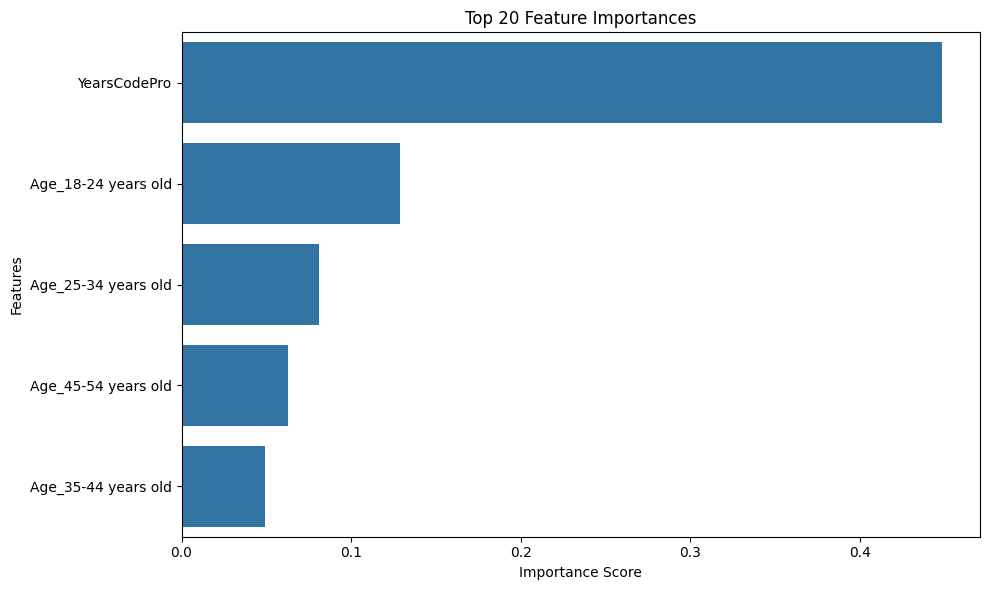

In [9]:
def get_feature_names(preprocessor):
    num_features = preprocessor.named_transformers_['num'].get_feature_names_out()
    cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out()
    return np.concatenate([num_features, cat_features])

# Get proper feature names after transformation
feature_names = get_feature_names(preprocessor)
plot_feature_importance(rf_model, feature_names)

### Multiclass Precision-Recall Curve Plotting

This cell prepares and plots precision-recall curves for a multiclass classification model using a one-vs-rest strategy.

- `label_binarize()` is used to convert the multiclass `y_test` labels into a binary format for each class.
- `predict_proba()` returns the class probabilities from the trained model.
- A loop iterates through each class, and the `plot_precision_recall()` function is called to generate a separate precision-recall curve for each class.

This approach allows visual inspection of model performance for each individual class, helping to identify where the model performs well or struggles.

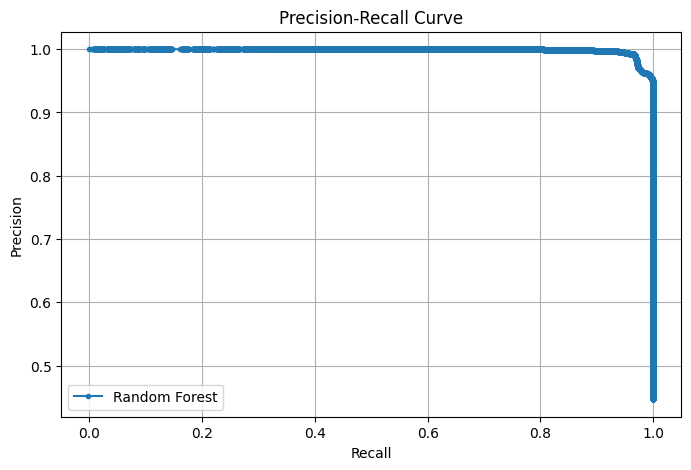

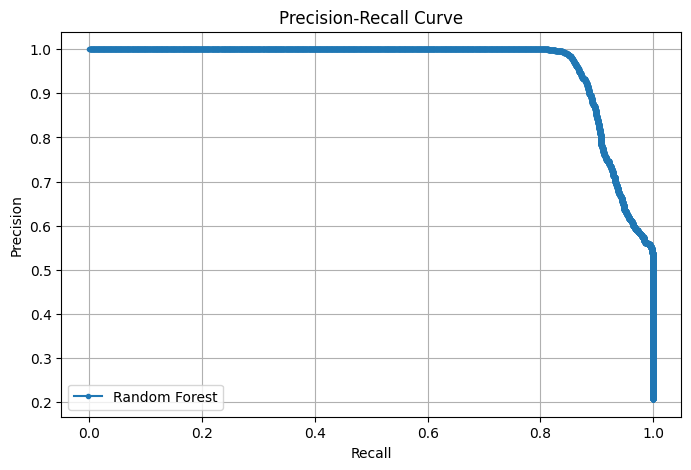

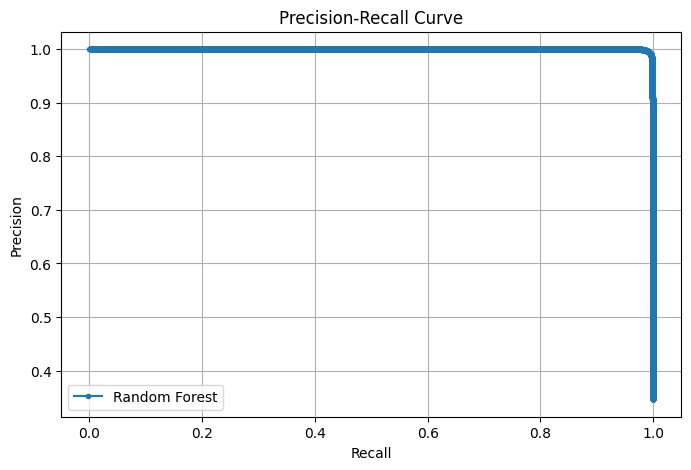

In [10]:
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_scores = rf_model.predict_proba(X_test_selected)

for i, class_label in enumerate(np.unique(y_test)):
    plot_precision_recall(y_test_bin[:, i], y_scores[:, i])

### Prediction Distribution Plot

This cell calls the `plot_prediction_distribution()` function to visualize the frequency of each predicted class label made by the model.

- It provides a simple bar chart showing how many samples were predicted for each class.
- This helps evaluate whether the model is favoring certain classes over others, which can be particularly useful when dealing with class imbalance.
- The plot is based on the final predictions (`y_pred_rf`) from the Random Forest model.


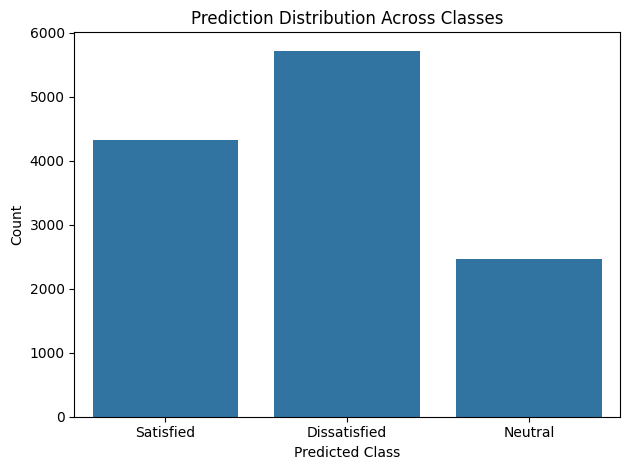

In [11]:
# Prediction distribution
plot_prediction_distribution(y_pred_rf)

### Cross-Validation Score Distribution Plot

This cell calls the `plot_cv_scores()` function to visualize the distribution of cross-validation accuracy scores.

- It displays a boxplot summarizing the accuracy scores across the cross-validation folds.
- The plot helps identify the variability in model performance across different training subsets.
- It provides insight into how stable and reliable the model is during training and evaluation.

This visualization is useful for understanding the consistency of model accuracy and spotting potential overfitting or underfitting.


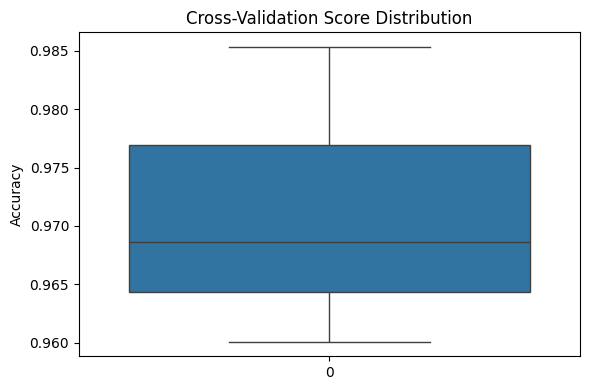

In [12]:
# CV score distribution
plot_cv_scores(cv_scores)

### Precision-Recall Curves for Multiclass Logistic Regression

This cell generates precision-recall curves for each class in a multiclass classification task using a logistic regression model.

- `predict_proba()` is used to get the class probabilities for each test instance.
- `label_binarize()` converts the multiclass true labels (`y_test`) into a binary indicator matrix suitable for one-vs-rest evaluation.
- A loop iterates over each class label, plotting a separate precision-recall curve using the corresponding binary true labels and predicted probabilities.

This analysis helps assess how well the model distinguishes each class individually and is particularly useful when classes are imbalanced.


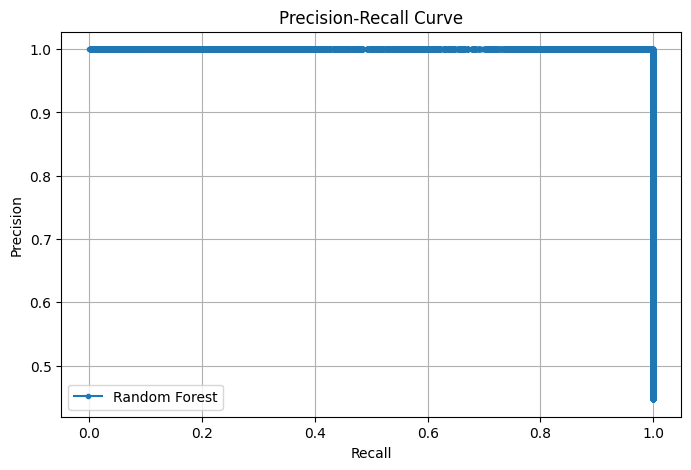

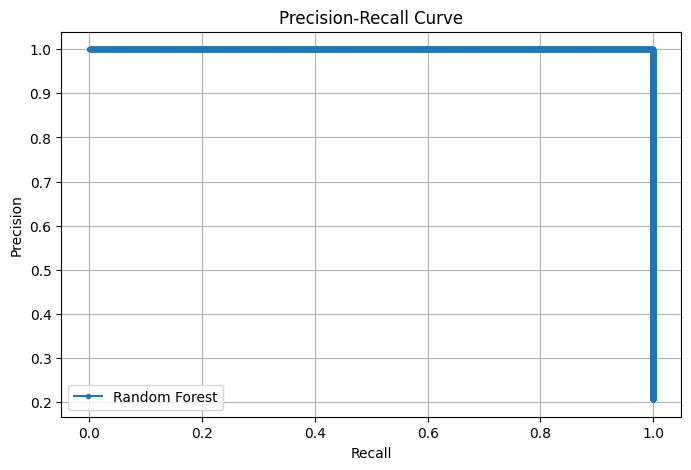

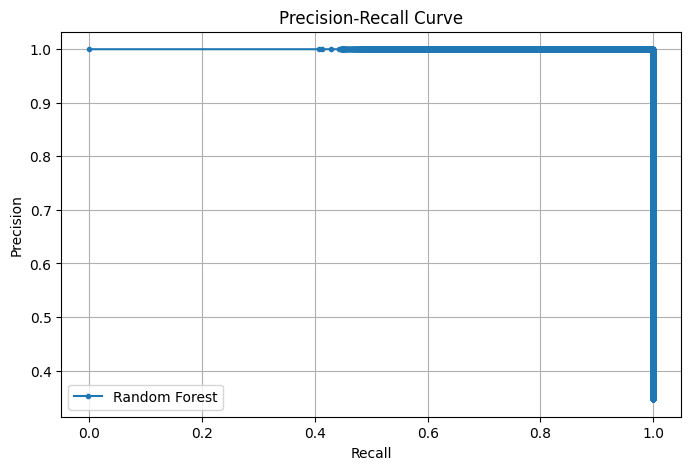

In [13]:
# For precision-recall:
from sklearn.preprocessing import label_binarize
y_scores = lr_model.predict_proba(X_test_sel)
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

for i, label in enumerate(np.unique(y_test)):
    plot_precision_recall(y_test_bin[:, i], y_scores[:, i])

### Multiclass ROC Curve Plot

This cell defines the function `plot_multiclass_roc()` for visualizing ROC (Receiver Operating Characteristic) curves in a multiclass classification setting.

- The function first uses `label_binarize()` to convert the true labels into a binary indicator matrix, enabling one-vs-rest evaluation for each class.
- It calculates the false positive rate (FPR), true positive rate (TPR), and AUC (Area Under the Curve) for each class using `roc_curve()` and `auc()`.
- Each class's ROC curve is plotted on the same figure for side-by-side comparison.
- A diagonal reference line represents the performance of a random classifier.

This plot provides insight into the ability of the model to distinguish between each class and is helpful for understanding class-wise separability and performance.


In [14]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_multiclass_roc(y_true, y_score, classes):
    y_true_bin = label_binarize(y_true, classes=classes)
    plt.figure(figsize=(8, 6))

    for i, class_label in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_label} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', linewidth=0.6)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Call to Multiclass ROC Curve Plot

This cell prepares the necessary inputs and calls the `plot_multiclass_roc()` function to generate ROC curves for a multiclass logistic regression model.

- `np.unique(y_test)` retrieves the sorted list of class labels present in the test set.
- `predict_proba()` generates the predicted probability scores for each class using the trained logistic regression model.
- The `plot_multiclass_roc()` function is then called with the true labels, predicted probabilities, and class list to display ROC curves for each class.

This visualization helps assess how well the model distinguishes between each class based on the trade-off between true positive rate and false positive rate.

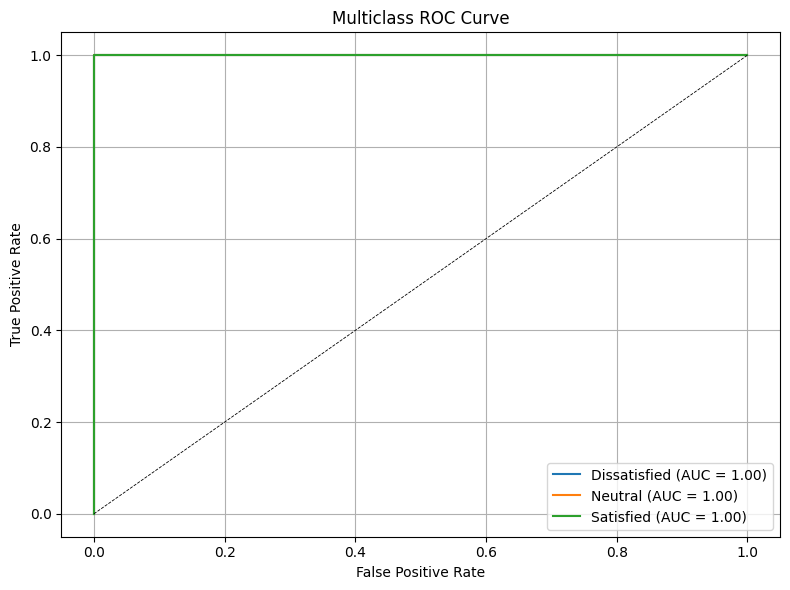

In [15]:
classes = np.unique(y_test)
y_scores = lr_model.predict_proba(X_test_sel)
plot_multiclass_roc(y_test, y_scores, classes)


### Predicted Class Probability Distribution

This cell defines the function `plot_class_probabilities()` to visualize how confident the model is in its predictions.

- The function takes the predicted probability matrix (`y_probs`) and extracts the maximum probability assigned to each prediction (i.e., the confidence level).
- A histogram is plotted to show the distribution of these maximum predicted probabilities across all test samples.
- The `kde=True` argument adds a smooth density curve for better interpretability.

This plot helps to understand the confidence level of the model's predictions, and it can be useful for detecting overconfident or uncertain classifications.

In [16]:
def plot_class_probabilities(y_probs, y_pred):
    plt.figure(figsize=(8, 6))
    sns.histplot(np.max(y_probs, axis=1), kde=True, bins=20)
    plt.title('Distribution of Maximum Predicted Probabilities')
    plt.xlabel('Max Predicted Probability')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

### Call to Predicted Class Probability Distribution Plot

This cell calls the `plot_class_probabilities()` function to visualize the distribution of the model’s prediction confidence on the test set.

- `predict_proba()` generates the class probability estimates for each instance in the test data.
- The function uses the maximum probability from each prediction to assess how confident the model was in choosing the predicted class.
- The resulting plot helps evaluate whether the model is generally making high-confidence predictions or is uncertain in many cases.

This visualization is useful for diagnosing model certainty and identifying potentially ambiguous predictions.


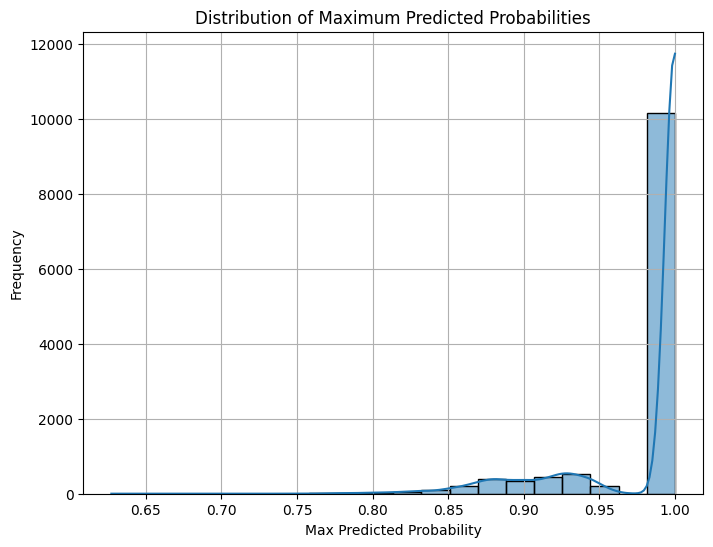

In [17]:
plot_class_probabilities(lr_model.predict_proba(X_test_sel), y_pred_test)